In [1]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars
from models.load import get_trained_model
from utils.coco_eval import get_eval_params_dict
from data.datasets import  OurRadiologsitsDataset, collate_fn
from our_radiologist.load import get_anns
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.coco_utils import get_cocos, get_coco_api_from_dataset
from utils.eval import get_ar_ap
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
from utils.constants import full_iou_thrs, iou_thrs_5to95
from data.load  import seed_worker, get_dataloader_g
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange
from collections import OrderedDict

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from utils.save import get_data_from_metric_logger
from data.datasets import ReflacxDataset, collate_fn
from utils.detect_utils import MetricLogger
from utils.coco_eval import CocoEvaluator, external_summarize
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo
from models.build import create_model_from_setup


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    CXR_Clinial_fusion1_fusion2="val_ar_0_5436_ap_0_1911_test_ar_0_5476_ap_0_3168_epoch49_WithClincal_05-23-2022 12-06-22_CXR_Clinical_roi_heads_spatialisation"
    CXR="val_ar_0_5271_ap_0_1785_test_ar_0_5737_ap_0_2089_epoch45_WithoutClincal_05-24-2022 12-27-53_CXR"


In [4]:
naming_map = {
    # TrainedModels.with_clinical: "with_clinical_best",
    # TrainedModels.with_clinical_final: "with_clinical_final",
    TrainedModels.CXR: "CXR",
    # TrainedModels.without_clinical_final: "without_clinical_final",
    TrainedModels.CXR_Clinial_fusion1_fusion2: "CXR+Clinial (fusion1+fusion2)"
}

In [5]:
select_model = TrainedModels.CXR_Clinial_fusion1_fusion2
model, train_info, _, _ = get_trained_model(
    select_model,
    DEFAULT_REFLACX_LABEL_COLS,
    device,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)
model.to(device)
model.eval()



Load custom model
Using pretrained backbone. mobilenet_v3
Using pretrained backbone. mobilenet_v3
Using SGD as optimizer with lr=0.001


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    

In [6]:
from data.transforms import get_transform

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": True,
    "dataset_mode": 'normal',
    "bbox_to_mask": False,
    "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
}

detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

In [7]:
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

def plot_model_bb_for_dataset_idx(
    model: nn.Module,
    train_info: TrainingInfo,
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
    score_thres: Dict = None,
    roi_head_thrs=None,
    plot_gt= False,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    data = dataset.prepare_input_from_data(data, device)
    imgs, clinical_num, clinical_cat, targets = data

    clinical_series = dataset.df.iloc[idx][dataset.clinical_cols]
    clinical_series["gender"] = dataset.encoders_map["gender"].inverse_transform(
        [clinical_series["gender"]]
    )[0]

    ## Get the pred for model.
    model.eval()
    if roi_head_thrs:
        model.roi_heads.score_thresh = roi_head_thrs
    if train_info.model_setup.use_clinical:
        _, pred = model(imgs, clinical_num, clinical_cat)
    else:
        _, pred = model(imgs)
    if score_thres:
        pred = pred_thrs_check(pred, dataset, score_thres, device)

    bb_fig = plot_bbox_for_model(
        idx=idx,
        clinical_series=clinical_series,
        target =targets[0],
        pred = pred[0],
        label_idx_to_disease = dataset.label_idx_to_disease,
        legend_elements = legend_elements,
        disease_color_code_map = disease_cmap["solid"],
        plot_gt= plot_gt,
    )

    return bb_fig


def plot_bbox_for_model(
    idx:int,
    clinical_series: pd.Series,
    target: List[Dict],
    pred: Dict,
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
    plot_gt: bool = False,
) -> Figure:

    # clinical + original image + preds
    num_bboxes = len(pred["boxes"])
    slot_size = num_bboxes + 2 ## clinical data and original image
    pred_start_idx = 2

    if plot_gt:
        slot_size +=1
        pred_start_idx +=1 

    fig, axes = plt.subplots(
        1, slot_size, figsize=(slot_size * 10, 10), dpi=120, sharex=True
    )
    img_path = target["image_path"]

    fig.suptitle(f"{img_path} ({idx})")

    fig.legend(handles=legend_elements, loc="upper right")

    img = PIL.Image.open(target["image_path"]).convert("RGB")

    # show the image in every matrix.
    for ax in axes[1:]:
        ax.imshow(img)

    # we plot the tabular data over here.
    axes[0].set_title(f"Clinical Data")
    table = axes[0].table(
        cellText=[[v] for v in clinical_series.values],
        rowLabels=clinical_series.index,
        loc="center right",
        colWidths=[0.1, 0.1],
    )
    table.scale(2, 4)
    table.set_fontsize(85)
    axes[0].axis("off")
    # axes[0].axis("tight")

    axes[1].set_title(f"Original CXR")

    # plot gt.

    if plot_gt:
        gt_ax_i = 2
        axes[gt_ax_i].set_title(
            f"Ground Truth ({len(target['boxes'].detach().cpu().numpy())})"
        )

        for label, bbox in zip(
            target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy(),
        ):
            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            axes[gt_ax_i].add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            axes[gt_ax_i].text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

    # plot pred.
    # for the predictions. generate the recs, and draw it on fig.
    for i, (label, bbox, score) in enumerate(zip(
        pred["labels"].detach().cpu().numpy(),
        pred["boxes"].detach().cpu().numpy(),
        pred["scores"].detach().cpu().numpy(),
    )):
        ax = axes[i + pred_start_idx]
        disease = label_idx_to_disease(label)
        ax.set_title(f"Prediction_{disease} ({i+1})")   
        c = disease_color_code_map[disease]

        ax.add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        ax.text(
            bbox[0],
            bbox[1],
            f"{disease} ({score:.2f})",
            color="black",
            backgroundcolor=c,
        )

    # plt.plot()
    # plt.pause(0.01)

    # fig.tight_layout()

    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


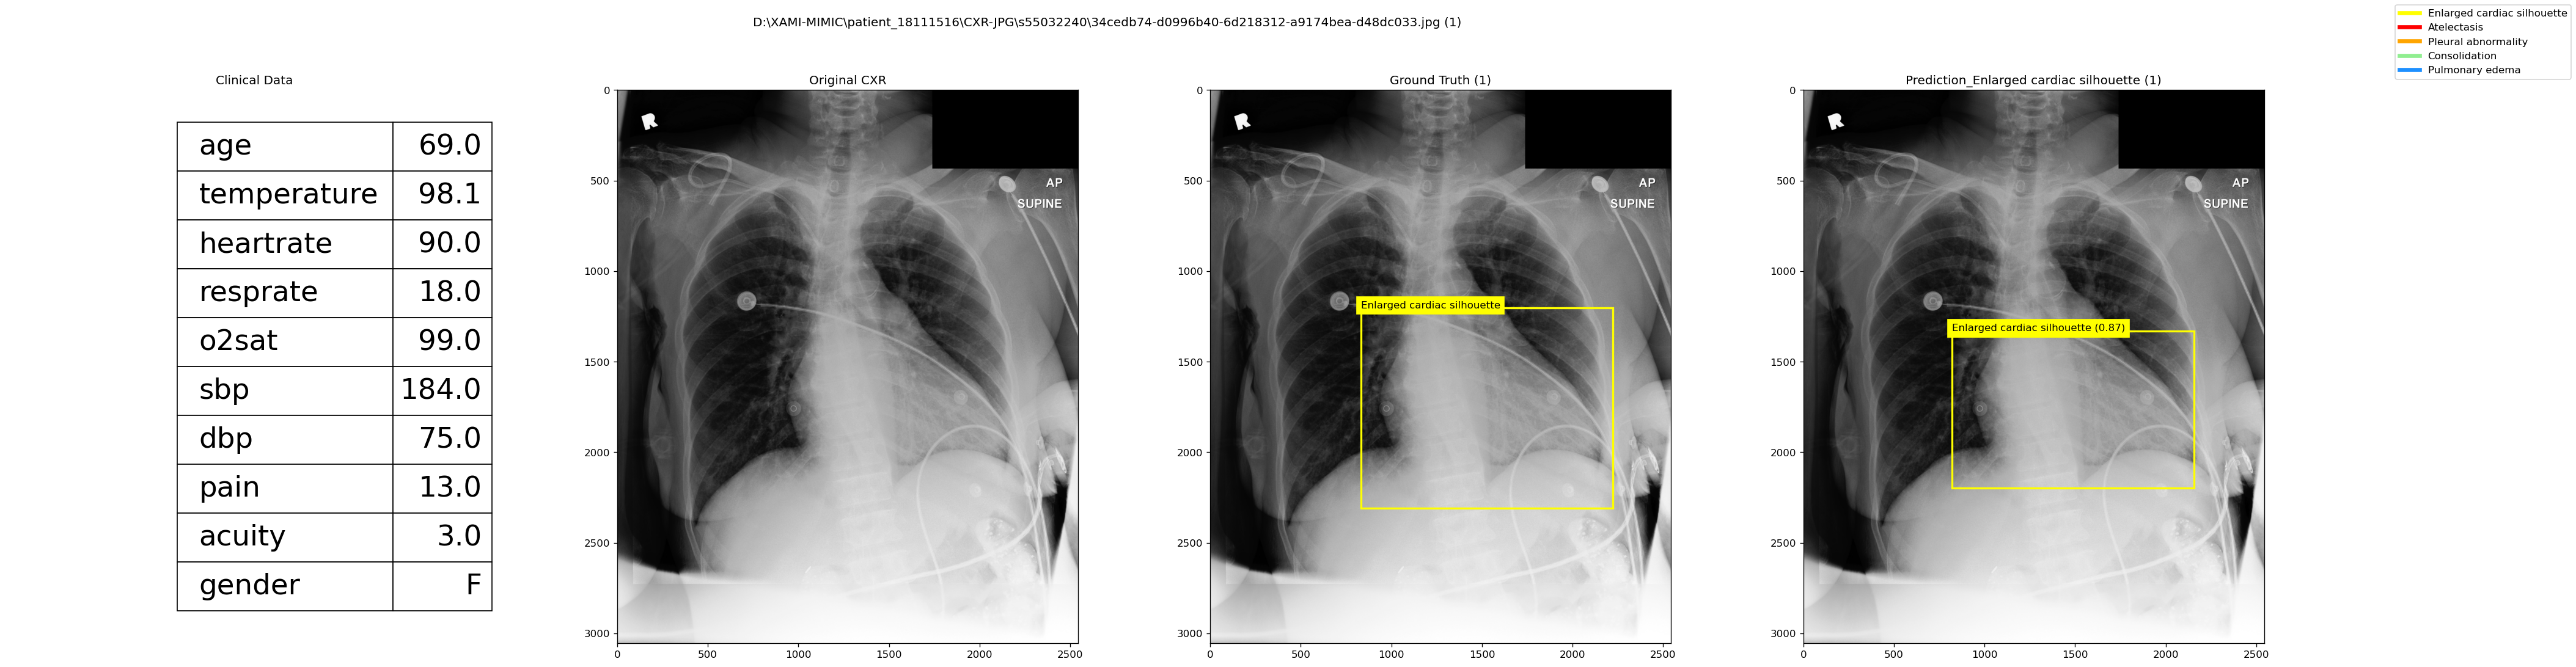

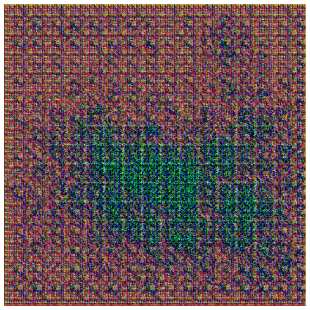

In [8]:
dataset = detect_eval_dataset
idx= 1

data = collate_fn([dataset[idx]])
data = dataset.prepare_input_from_data(data, device)
imgs, clinical_num, clinical_cat, targets = data

clinical_series = dataset.df.iloc[idx][dataset.clinical_cols]
clinical_series["gender"] = dataset.encoders_map["gender"].inverse_transform(
    [clinical_series["gender"]]
)[0]

## Get the pred for model.
model.eval()
_, pred = model(imgs, clinical_num, clinical_cat)
fig = plot_model_bb_for_dataset_idx(
    model=model,
    train_info=train_info,
    dataset=detect_eval_dataset,
    device=device,
    idx=idx,
    legend_elements=legend_elements,
    disease_cmap=DISEASE_CMAP,
    score_thres=None,
    roi_head_thrs=0.5,
    plot_gt=True,
)


img_numpy = model.clinical_expanded_input.squeeze().permute(1, 2, 0).detach().cpu().numpy()
fig = plt.figure(
    figsize=(10, 10), dpi=40,
)
plt.imshow(img_numpy)
plt.axis('off')
plt.show()
